### Initial Data Set Up

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import ta
from ta import momentum
import ccxt
import hvplot
import hvplot.pandas
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from datetime import datetime, timedelta, timezone, date
from bokeh.models import Range1d, LinearAxis
from bokeh.models.renderers import GlyphRenderer
from sklearn import metrics
from sklearn.metrics import log_loss

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Get data from Binance exchange
exchange_class = getattr(ccxt,'binance') #note data pulling from Binance
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

### We set the ticker first and the data we require to be pulled from the API

In [2]:
# Data function to get data depending on timeframe
# note API limit to 1000 units
def get_symbol_history(symbol,timeframe,start_date,end_date):
    
    if time_frame == '15m':
        # 1000 x 15m = 10 days
        freq = '10D'
    elif time_frame == '1h':
        # 1000 hours = 41 days
        freq = '41D'
    elif time_frame == '4h':
        # 1000 x 4h = 3 years
        freq = '166D'
    elif time_frame == '1d':
        # 1000 x 1d = 3 years
        freq = '3Y'
    
    period_starts = list(pd.date_range(start=start_date, end=end_date,freq=freq,tz='UTC').astype(np.int64))
    
    df = pd.DataFrame()
    for month in period_starts:
        since = int(month/1000000)
        new_df = pd.DataFrame(exchange.fetch_ohlcv(symbol, time_frame,since=since,limit=1000))
        if len(new_df) > 0:
            df = df.append(new_df)
    if len(df)>0:
        header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = header
    
    df = df.drop_duplicates() 
    df.reset_index(drop=True) 

    df.index = pd.to_datetime(df['Timestamp'],unit='ms')
    df.drop(columns = ['Timestamp'],inplace=True)
    
    return df

In [3]:
# Set data date range, timeframe and trading pair/ symbol
start_date = '16/05/2021' #71 days 'short term model' example
end_date = '25/07/2021'
time_frame = '1h' 
symbol = 'BTC/USDT'

raw_df = get_symbol_history(symbol,time_frame,start_date,end_date)

In [4]:
btc_df = raw_df.copy()

In [5]:
btc_df


Open      High       Low     Close       Volume
Timestamp                                                               
2021-05-16 00:00:00  46762.99  47698.00  46467.00  47283.43  5439.308207
2021-05-16 01:00:00  47282.38  48215.96  47282.37  48059.99  3005.465226
2021-05-16 02:00:00  48059.99  48326.62  47952.56  48150.01  2151.761047
2021-05-16 03:00:00  48144.25  48406.44  47747.70  48383.46  2204.566902
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438
...                       ...       ...       ...       ...          ...
2021-07-25 08:00:00  34695.51  34800.00  34455.58  34570.89  2166.492075
2021-07-25 09:00:00  34574.61  34632.78  34339.05  34509.03  1895.689073
2021-07-25 10:00:00  34509.02  34580.76  34238.56  34353.56  1872.364973
2021-07-25 11:00:00  34353.57  34498.46  34276.62  34399.04  1871.234406
2021-07-25 12:00:00  34399.04  34434.06  34242.41  34424.70   914.973503

[1693 rows x 5 columns]

In [6]:
btc_df.head()

Open      High       Low     Close       Volume
Timestamp                                                               
2021-05-16 00:00:00  46762.99  47698.00  46467.00  47283.43  5439.308207
2021-05-16 01:00:00  47282.38  48215.96  47282.37  48059.99  3005.465226
2021-05-16 02:00:00  48059.99  48326.62  47952.56  48150.01  2151.761047
2021-05-16 03:00:00  48144.25  48406.44  47747.70  48383.46  2204.566902
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438

In [7]:
# Drop NAs and calculate daily percent return
btc_df["period_return"] = btc_df["Close"].dropna().pct_change()
btc_df["target"] = btc_df["Close"].dropna().pct_change(4) #24 hours sets the basis of our short term strategy

# Display sample data
btc_df.tail()

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-07-25 08:00:00  34695.51  34800.00  34455.58  34570.89  2166.492075   
2021-07-25 09:00:00  34574.61  34632.78  34339.05  34509.03  1895.689073   
2021-07-25 10:00:00  34509.02  34580.76  34238.56  34353.56  1872.364973   
2021-07-25 11:00:00  34353.57  34498.46  34276.62  34399.04  1871.234406   
2021-07-25 12:00:00  34399.04  34434.06  34242.41  34424.70   914.973503   

                     period_return    target  
Timestamp                                     
2021-07-25 08:00:00      -0.003592  0.005962  
2021-07-25 09:00:00      -0.001789  0.005440  
2021-07-25 10:00:00      -0.004505 -0.003440  
2021-07-25 11:00:00       0.001324 -0.008545  
2021-07-25 12:00:00       0.000746 -0.004229

In [8]:
hounds_cap_investment = 40000

### Exponential Weighted Moving Average Indicator

In [9]:
# Set short and long windows
short_window = 3
long_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_close"] = btc_df["Close"].ewm(halflife=short_window).mean()
btc_df["slow_close"] = btc_df["Close"].ewm(halflife=long_window).mean()

# Crossover trading indicator
btc_df["crossover_long"] = np.where(btc_df["fast_close"] > btc_df["slow_close"], 1.0, 0.0)
btc_df["crossover_short"] = np.where(btc_df["fast_close"] < btc_df["slow_close"], -1.0, 0.0)
btc_df["crossover_signal"] = btc_df["crossover_long"] + btc_df["crossover_short"]
btc_df['Cross Entry/Exit'] = btc_df["crossover_signal"].diff()
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].replace(-2,-1).replace(2,1)

#btc_df.loc[btc_df['Cross Entry/Exit']==1]


In [10]:
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].fillna(0)

In [11]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['Cross Entry/Exit']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['Cross Entry/Exit']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1


#btc_df.to_csv('test.csv')

In [12]:
btc_df.tail()

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-07-25 08:00:00  34695.51  34800.00  34455.58  34570.89  2166.492075   
2021-07-25 09:00:00  34574.61  34632.78  34339.05  34509.03  1895.689073   
2021-07-25 10:00:00  34509.02  34580.76  34238.56  34353.56  1872.364973   
2021-07-25 11:00:00  34353.57  34498.46  34276.62  34399.04  1871.234406   
2021-07-25 12:00:00  34399.04  34434.06  34242.41  34424.70   914.973503   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-07-25 08:00:00      -0.003592  0.005962  34381.555007  33986.161807   
2021-07-25 09:00:00      -0.001789  0.005440  34407.853031  34021.176726   
2021-07-25 10:00:00      -0.004505 -0.003440  34396.652407  34043.435439   
2021-07-25 11:00:00       0.001324 -0.008545  34397.144966  34067.249213   
2021-07-25 12:00:00       0.000746 -0.004229  34402.829555  34091.186623   

                     crossover_long  crossover_short  crossover_signal  \
Timestamp                                                                
2021-07-25 08:00:00             1.0              0.0               1.0   
2021-07-25 09:00:00             1.0              0.0               1.0   
2021-07-25 10:00:00             1.0              0.0               1.0   
2021-07-25 11:00:00             1.0              0.0               1.0   
2021-07-25 12:00:00             1.0              0.0               1.0   

                     Cross Entry/Exit  Portfolio Cash  Coin Holdings  \
Timestamp                                                              
2021-07-25 08:00:00               0.0             0.0        1.20849   
2021-07-25 09:00:00               0.0             0.0        1.20849   
2021-07-25 10:00:00               0.0             0.0        1.20849   
2021-07-25 11:00:00               0.0             0.0        1.20849   
2021-07-25 12:00:00               0.0             0.0        1.20849   

                     Portfolio Holdings  Portfolio Total  Portfolio Returns  \
Timestamp                                                                     
2021-07-25 08:00:00        41778.562831     41778.562831          -0.003592   
2021-07-25 09:00:00        41703.805662     41703.805662          -0.001789   
2021-07-25 10:00:00        41515.921775     41515.921775          -0.004505   
2021-07-25 11:00:00        41570.883885     41570.883885           0.001324   
2021-07-25 12:00:00        41601.893729     41601.893729           0.000746   

                     Portolio Cumulative Returns  
Timestamp                                         
2021-07-25 08:00:00                     0.044464  
2021-07-25 09:00:00                     0.042595  
2021-07-25 10:00:00                     0.037898  
2021-07-25 11:00:00                     0.039272  
2021-07-25 12:00:00                     0.040047

<AxesSubplot:xlabel='Timestamp'>

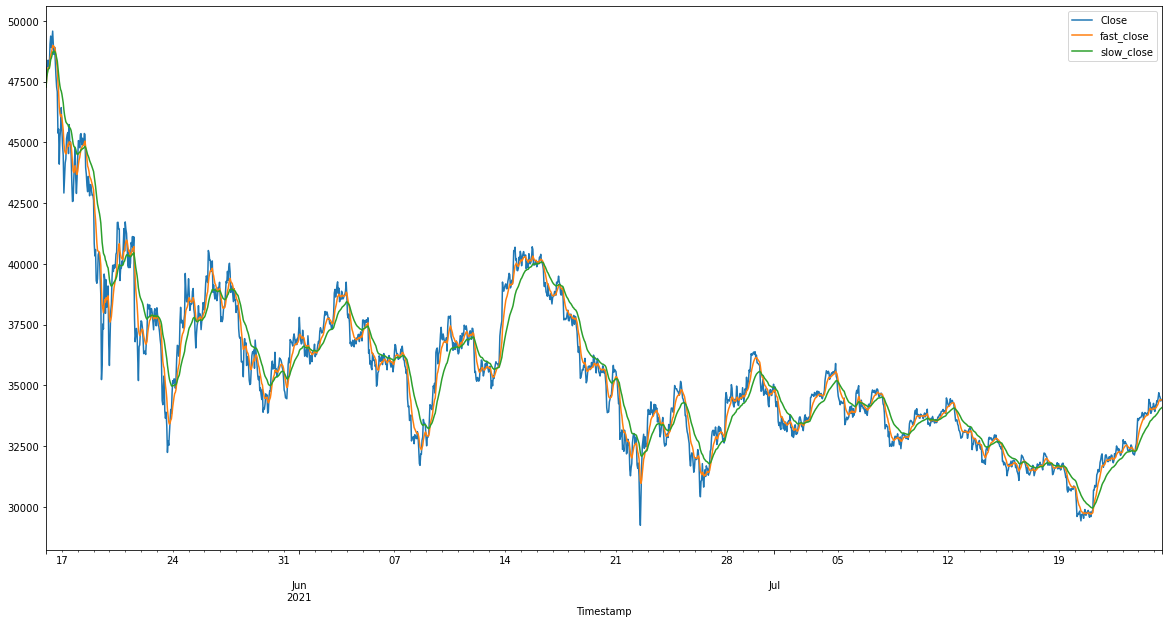

In [13]:
# Plot EMA of BTC/USD closing prices
btc_df[["Close", "fast_close", "slow_close"]].plot(figsize=(20,10))

In [14]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Cross Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Cross Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['fast_close', 'slow_close']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [15]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [16]:
# Return last value of dataframe to pull into lambda code
EMA = btc_df['Portfolio Total'].iloc[-1]
EMA

41601.893729222196

### Simple Moving Average

In [17]:
short_window = 7
long_window = 25

btc_df['ma_short'] = btc_df['Close'].rolling(window=short_window).mean()
btc_df['ma_long'] = btc_df['Close'].rolling(window=long_window).mean()

btc_df['ma_signal'] = 0
btc_df['ma_signal'] = np.where(btc_df['ma_short']>btc_df['ma_long'],1,0)
btc_df['Entry/Exit'] = btc_df['ma_signal'].diff()


In [18]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['Entry/Exit']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['Entry/Exit']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1


#btc_df.to_csv('test.csv')

In [19]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['ma_short', 'ma_long']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

<AxesSubplot:xlabel='Timestamp'>

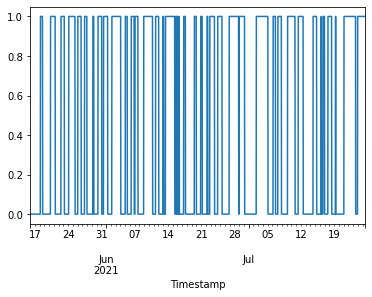

In [20]:
# Showing Bitcoin position at any time
btc_df['Entry/Exit'].cumsum().plot()

In [21]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [22]:
# Return last value of dataframe to pull into lambda code
SMA = btc_df['Portfolio Total'].iloc[-1]
SMA

32472.687558204005

### Volatility Indicator

In [23]:
# Set short and long volatility windows
short_vol_window = 7
long_vol_window = 25

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_vol"] = btc_df["period_return"].ewm(halflife=short_vol_window).std()
btc_df["slow_vol"] = btc_df["period_return"].ewm(halflife=long_vol_window).std()

# Crossover trading signal
btc_df["vol_trend_long"] = np.where(btc_df["fast_vol"] < btc_df["slow_vol"], 1.0, 0.0)
btc_df["vol_trend_short"] = np.where(btc_df["fast_vol"] > btc_df["slow_vol"], -1.0, 0.0) 
btc_df["vol_trend_signal"] = (btc_df["vol_trend_long"] + btc_df["vol_trend_short"]).diff()
btc_df["vol_trend_signal"] = btc_df["vol_trend_signal"].replace(-2,-1).replace(2,1)

btc_df

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 00:00:00  46762.99  47698.00  46467.00  47283.43  5439.308207   
2021-05-16 01:00:00  47282.38  48215.96  47282.37  48059.99  3005.465226   
2021-05-16 02:00:00  48059.99  48326.62  47952.56  48150.01  2151.761047   
2021-05-16 03:00:00  48144.25  48406.44  47747.70  48383.46  2204.566902   
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
...                       ...       ...       ...       ...          ...   
2021-07-25 08:00:00  34695.51  34800.00  34455.58  34570.89  2166.492075   
2021-07-25 09:00:00  34574.61  34632.78  34339.05  34509.03  1895.689073   
2021-07-25 10:00:00  34509.02  34580.76  34238.56  34353.56  1872.364973   
2021-07-25 11:00:00  34353.57  34498.46  34276.62  34399.04  1871.234406   
2021-07-25 12:00:00  34399.04  34434.06  34242.41  34424.70   914.973503   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 00:00:00            NaN       NaN  47283.430000  47283.430000   
2021-05-16 01:00:00       0.016424       NaN  47716.367377  47685.161374   
2021-05-16 02:00:00       0.001873       NaN  47895.287867  47850.966536   
2021-05-16 03:00:00       0.004848       NaN  48062.260756  47998.233578   
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
...                            ...       ...           ...           ...   
2021-07-25 08:00:00      -0.003592  0.005962  34381.555007  33986.161807   
2021-07-25 09:00:00      -0.001789  0.005440  34407.853031  34021.176726   
2021-07-25 10:00:00      -0.004505 -0.003440  34396.652407  34043.435439   
2021-07-25 11:00:00       0.001324 -0.008545  34397.144966  34067.249213   
2021-07-25 12:00:00       0.000746 -0.004229  34402.829555  34091.186623   

                     crossover_long  ...  Portolio Cumulative Returns  \
Timestamp                            ...                                
2021-05-16 00:00:00             0.0  ...                          NaN   
2021-05-16 01:00:00             1.0  ...                     0.000000   
2021-05-16 02:00:00             1.0  ...                     0.000000   
2021-05-16 03:00:00             1.0  ...                     0.000000   
2021-05-16 04:00:00             1.0  ...                     0.000000   
...                             ...  ...                          ...   
2021-07-25 08:00:00             1.0  ...                    -0.184735   
2021-07-25 09:00:00             1.0  ...                    -0.186194   
2021-07-25 10:00:00             1.0  ...                    -0.189860   
2021-07-25 11:00:00             1.0  ...                    -0.188788   
2021-07-25 12:00:00             1.0  ...                    -0.188183   

                         ma_short     ma_long  ma_signal  Entry/Exit  \
Timestamp                                                              
2021-05-16 00:00:00           NaN         NaN          0         NaN   
2021-05-16 01:00:00           NaN         NaN          0         0.0   
2021-05-16 02:00:00           NaN         NaN          0         0.0   
2021-05-16 03:00:00           NaN         NaN          0         0.0   
2021-05-16 04:00:00           NaN         NaN          0         0.0   
...                           ...         ...        ...         ...   
2021-07-25 08:00:00  34395.078571  34093.6768          1         0.0   
2021-07-25 09:00:00  34442.390000  34129.5588          1         0.0   
2021-07-25 10:00:00  34469.920000  34150.3560          1         0.0   
2021-07-25 11:00:00  34474.641429  34171.1908          1         0.0   
2021-07-25 12:00:00  34489.268571  34193.4988          1         0.0   

                     fast_vol  slow_vol  vol_trend_long  vol_trend_short  \
Timestamp                                                                  
2021-05-

<AxesSubplot:xlabel='Timestamp'>

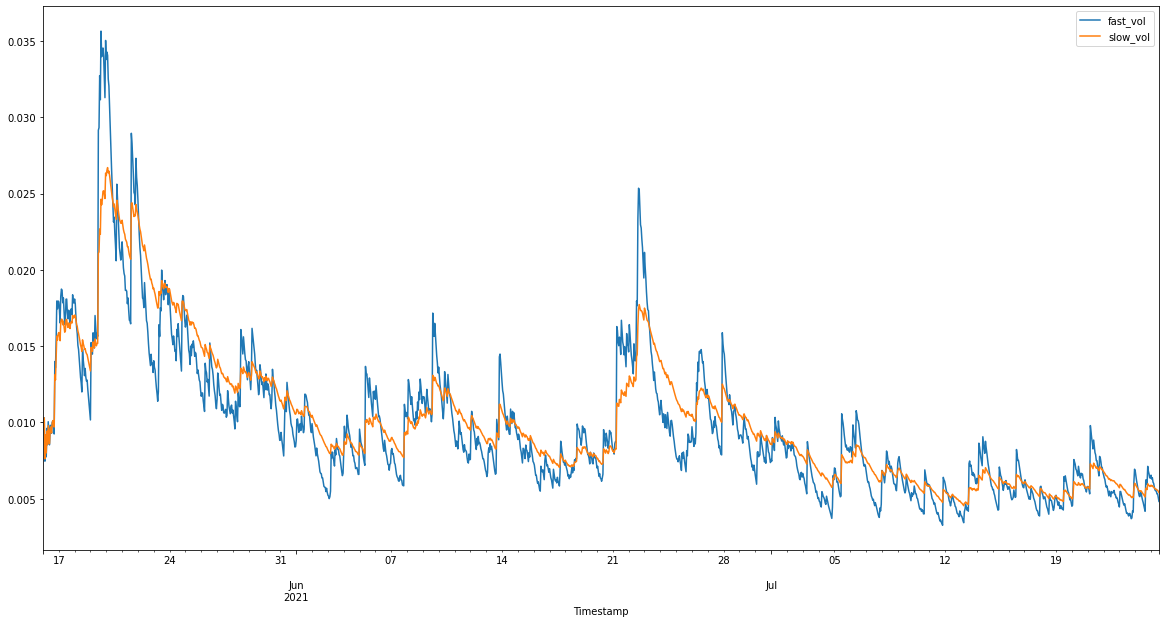

In [24]:
# Plot EMA of BTC/USD daily return volatility
btc_df[["fast_vol", "slow_vol"]].plot(figsize=(20,10))

In [25]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['vol_trend_signal'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['vol_trend_signal'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [26]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['vol_trend_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['vol_trend_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [27]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [28]:
# Return last value of dataframe to pull into lambda code
VOL = btc_df['Portfolio Total'].iloc[-1]
VOL


42422.24653582489

### Bollinger Bands Indicator

In [29]:
# Set bollinger band window
bollinger_window = 20

# Rolling mean and standard deviation
btc_df["bollinger_mid_band"] = btc_df["Close"].rolling(window=bollinger_window).mean()
btc_df["bollinger_std"] = btc_df["Close"].rolling(window=20).std()

# Upper and lowers bands of bollinger band
btc_df["bollinger_upper_band"]  = btc_df["bollinger_mid_band"] + (btc_df["bollinger_std"] * 1)
btc_df["bollinger_lower_band"]  = btc_df["bollinger_mid_band"] - (btc_df["bollinger_std"] * 1)

# Bollinger band trading signal
btc_df["bollinger_long"] = np.where(btc_df["Close"] < btc_df["bollinger_lower_band"], 1.0, 0.0)
btc_df["bollinger_long"] = np.where(btc_df["Close"] > btc_df["bollinger_lower_band"], -1.0, 0.0)

# inferred correlation between long and short indicators so decided to just use long - would make the model more advanced and assess correlation between both 
#btc_df["bollinger_short"] = np.where(btc_df["Close"] > btc_df["bollinger_upper_band"], 1.0, 0.0)
#btc_df["bollinger_short"] = np.where(btc_df["Close"] < btc_df["bollinger_upper_band"], -1.0, 0.0)

btc_df["bollinger_signal"] = btc_df["bollinger_long"] # + btc_df["bollinger_short"] - remove if only using one band
btc_df["bollinger_signal"] = btc_df["bollinger_signal"].diff()
#btc_df["vol_trend_signal"] = btc_df["vol_trend_signal"].replace(-2,-1).replace(2,1)

btc_df

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 00:00:00  46762.99  47698.00  46467.00  47283.43  5439.308207   
2021-05-16 01:00:00  47282.38  48215.96  47282.37  48059.99  3005.465226   
2021-05-16 02:00:00  48059.99  48326.62  47952.56  48150.01  2151.761047   
2021-05-16 03:00:00  48144.25  48406.44  47747.70  48383.46  2204.566902   
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
...                       ...       ...       ...       ...          ...   
2021-07-25 08:00:00  34695.51  34800.00  34455.58  34570.89  2166.492075   
2021-07-25 09:00:00  34574.61  34632.78  34339.05  34509.03  1895.689073   
2021-07-25 10:00:00  34509.02  34580.76  34238.56  34353.56  1872.364973   
2021-07-25 11:00:00  34353.57  34498.46  34276.62  34399.04  1871.234406   
2021-07-25 12:00:00  34399.04  34434.06  34242.41  34424.70   914.973503   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 00:00:00            NaN       NaN  47283.430000  47283.430000   
2021-05-16 01:00:00       0.016424       NaN  47716.367377  47685.161374   
2021-05-16 02:00:00       0.001873       NaN  47895.287867  47850.966536   
2021-05-16 03:00:00       0.004848       NaN  48062.260756  47998.233578   
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
...                            ...       ...           ...           ...   
2021-07-25 08:00:00      -0.003592  0.005962  34381.555007  33986.161807   
2021-07-25 09:00:00      -0.001789  0.005440  34407.853031  34021.176726   
2021-07-25 10:00:00      -0.004505 -0.003440  34396.652407  34043.435439   
2021-07-25 11:00:00       0.001324 -0.008545  34397.144966  34067.249213   
2021-07-25 12:00:00       0.000746 -0.004229  34402.829555  34091.186623   

                     crossover_long  ...  slow_vol  vol_trend_long  \
Timestamp                            ...                             
2021-05-16 00:00:00             0.0  ...       NaN             0.0   
2021-05-16 01:00:00             1.0  ...       NaN             0.0   
2021-05-16 02:00:00             1.0  ...  0.010289             0.0   
2021-05-16 03:00:00             1.0  ...  0.007626             1.0   
2021-05-16 04:00:00             1.0  ...  0.009189             1.0   
...                             ...  ...       ...             ...   
2021-07-25 08:00:00             1.0  ...  0.005620             1.0   
2021-07-25 09:00:00             1.0  ...  0.005564             1.0   
2021-07-25 10:00:00             1.0  ...  0.005562             1.0   
2021-07-25 11:00:00             1.0  ...  0.005486             1.0   
2021-07-25 12:00:00             1.0  ...  0.005411             1.0   

                     vol_trend_short  vol_trend_signal  bollinger_mid_band  \
Timestamp                                                                    
2021-05-16 00:00:00              0.0               NaN                 NaN   
2021-05-16 01:00:00              0.0               0.0                 NaN   
2021-05-16 02:00:00             -1.0              -1.0                 NaN   
2021-05-16 03:00:00              0.0               1.0                 NaN   
2021-05-16 04:00:00              0.0               0.0                 NaN   
...                              ...               ...                 ...   
2021-07-25 08:00:00              0.0               0.0          34166.7280   
2021-07-25 09:00:00              0.0               0.0          34203.0250   
2021-07-25 10:00:00              0.0               0.0          34228.1310   
2021-07-25 11:00:00              0.0               0.0          34255.7075   
2021-07-25 12:00:00              0.0               0.0          34255.7685   

                     bollinger_std  bollinger_upper_band  \
Timestamp                                                  
2

<AxesSubplot:xlabel='Timestamp'>

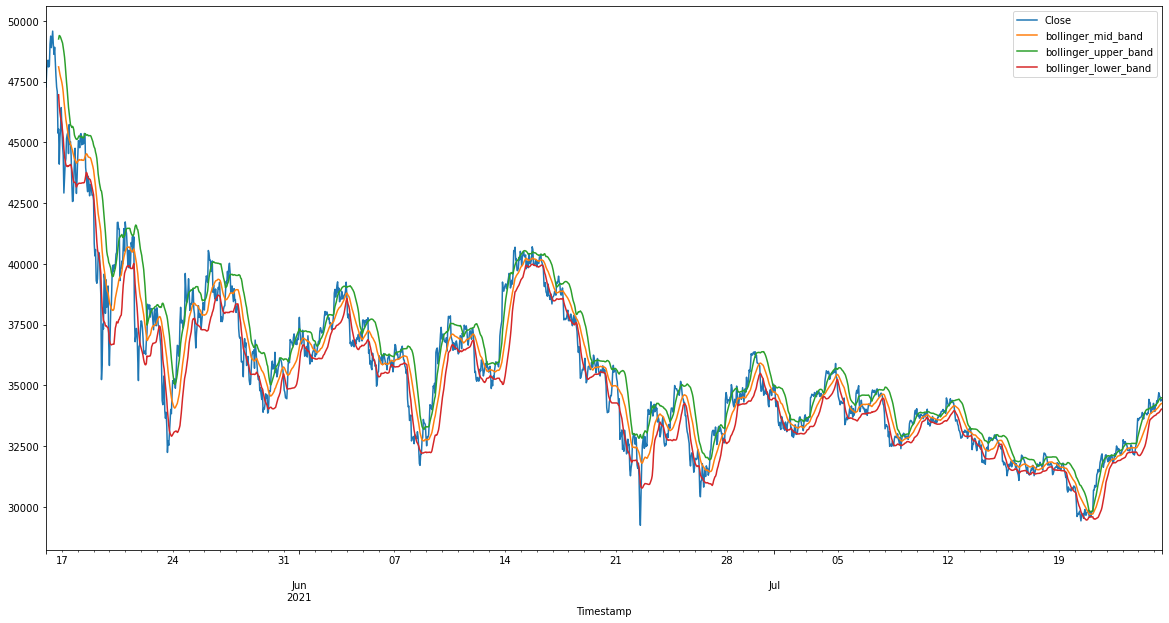

In [30]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[["Close","bollinger_mid_band","bollinger_upper_band","bollinger_lower_band"]].plot(figsize=(20,10))

In [31]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['bollinger_signal'] == 1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['bollinger_signal'] == -1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize upper bollinger band - for strategy
moving_avgs = btc_df['bollinger_upper_band'].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * entry * moving_avgs * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [Timestamp]   (Close)
   .Scatter.Close.I            :Scatter   [Timestamp]   (Close)
   .Curve.Bollinger_upper_band :Curve   [Timestamp]   (bollinger_upper_band)
   .Scatter.Close.II           :Scatter   [Timestamp]   (Close)

In [32]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['bollinger_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['bollinger_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [33]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [34]:
# Return last value of dataframe to pull into lambda code
BOL = btc_df['Portfolio Total'].iloc[-1]
BOL

33331.86001821218

### RSI Indicator

In [35]:
btc_df['rsi'] = momentum.RSIIndicator(btc_df['Close'],window=14).rsi()

btc_df["rsi_long"] = np.where(btc_df["rsi"] < 20, 1.0, 0.0)
btc_df["rsi_long"] = np.where(btc_df["rsi"] > 60, -1.0, 0.0)

btc_df["rsi_signal"] = btc_df["rsi_long"].diff().fillna(0)

In [36]:
btc_df.head()

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 00:00:00  46762.99  47698.00  46467.00  47283.43  5439.308207   
2021-05-16 01:00:00  47282.38  48215.96  47282.37  48059.99  3005.465226   
2021-05-16 02:00:00  48059.99  48326.62  47952.56  48150.01  2151.761047   
2021-05-16 03:00:00  48144.25  48406.44  47747.70  48383.46  2204.566902   
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 00:00:00            NaN       NaN  47283.430000  47283.430000   
2021-05-16 01:00:00       0.016424       NaN  47716.367377  47685.161374   
2021-05-16 02:00:00       0.001873       NaN  47895.287867  47850.966536   
2021-05-16 03:00:00       0.004848       NaN  48062.260756  47998.233578   
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   

                     crossover_long  ...  vol_trend_signal  \
Timestamp                            ...                     
2021-05-16 00:00:00             0.0  ...               NaN   
2021-05-16 01:00:00             1.0  ...               0.0   
2021-05-16 02:00:00             1.0  ...              -1.0   
2021-05-16 03:00:00             1.0  ...               1.0   
2021-05-16 04:00:00             1.0  ...               0.0   

                     bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                                      
2021-05-16 00:00:00                 NaN            NaN                   NaN   
2021-05-16 01:00:00                 NaN            NaN                   NaN   
2021-05-16 02:00:00                 NaN            NaN                   NaN   
2021-05-16 03:00:00                 NaN            NaN                   NaN   
2021-05-16 04:00:00                 NaN            NaN                   NaN   

                     bollinger_lower_band  bollinger_long  bollinger_signal  \
Timestamp                                                                     
2021-05-16 00:00:00                   NaN             0.0               NaN   
2021-05-16 01:00:00                   NaN             0.0               0.0   
2021-05-16 02:00:00                   NaN             0.0               0.0   
2021-05-16 03:00:00                   NaN             0.0               0.0   
2021-05-16 04:00:00                   NaN             0.0               0.0   

                     rsi  rsi_long  rsi_signal  
Timestamp                                       
2021-05-16 00:00:00  NaN       0.0         0.0  
2021-05-16 01:00:00  NaN       0.0         0.0  
2021-05-16 02:00:00  NaN       0.0         0.0  
2021-05-16 03:00:00  NaN       0.0         0.0  
2021-05-16 04:00:00  NaN       0.0         0.0  

[5 rows x 37 columns]

In [37]:
# Visualize exit position relative to Close price
entry = btc_df[btc_df['rsi_signal'] == 1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
exit = btc_df[btc_df['rsi_signal'] == -1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize - overlay onto secondary axis
def apply_formatter(plot, element):
    p = plot.state
    
    # create secondary range and axis
    p.extra_y_ranges = {"twiny": Range1d(start=0, end=1000)}
    p.add_layout(LinearAxis(y_range_name="twiny"), 'right')
    glyph = p.select(dict(type=GlyphRenderer))[0]
    glyph.y_range_name = 'twiny'

rsi_plot = btc_df["rsi"].hvplot(ylabel='Price in $',width=1000,height=400).opts(hooks=[apply_formatter])

# Overlay plots
entry_exit_plot = price * rsi_plot * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Curve.Rsi        :Curve   [Timestamp]   (rsi)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [38]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['rsi_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['rsi_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [39]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [40]:
# Return last value of dataframe to pull into lambda code
RSI = btc_df['Portfolio Total'].iloc[-1]
RSI

36423.94388185291

# Trading Signals/ Indicators for Random Forest Classifier
## 5 Model Input

In [41]:
trading_signals_df = btc_df.copy()

In [42]:
# Set x variable list of features
x_var_list = ["Cross Entry/Exit", "Entry/Exit", "vol_trend_signal", "bollinger_signal","rsi_signal"]


# Filter by x-variable list
trading_signals_df[x_var_list].tail()

Cross Entry/Exit  Entry/Exit  vol_trend_signal  \
Timestamp                                                             
2021-07-25 08:00:00               0.0         0.0               0.0   
2021-07-25 09:00:00               0.0         0.0               0.0   
2021-07-25 10:00:00               0.0         0.0               0.0   
2021-07-25 11:00:00               0.0         0.0               0.0   
2021-07-25 12:00:00               0.0         0.0               0.0   

                     bollinger_signal  rsi_signal  
Timestamp                                          
2021-07-25 08:00:00               0.0         0.0  
2021-07-25 09:00:00               0.0         0.0  
2021-07-25 10:00:00               0.0         1.0  
2021-07-25 11:00:00               0.0         0.0  
2021-07-25 12:00:00               0.0         0.0

In [43]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

Cross Entry/Exit  Entry/Exit  vol_trend_signal  \
Timestamp                                                             
2021-05-16 00:00:00               NaN         NaN               NaN   
2021-05-16 01:00:00               0.0         NaN               NaN   
2021-05-16 02:00:00               1.0         0.0               0.0   
2021-05-16 03:00:00               0.0         0.0              -1.0   
2021-05-16 04:00:00               0.0         0.0               1.0   

                     bollinger_signal  rsi_signal  
Timestamp                                          
2021-05-16 00:00:00               NaN         NaN  
2021-05-16 01:00:00               NaN         0.0  
2021-05-16 02:00:00               0.0         0.0  
2021-05-16 03:00:00               0.0         0.0  
2021-05-16 04:00:00               0.0         0.0

In [44]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
2021-05-16 05:00:00  48102.77  48354.20  48034.82  48165.86  1650.211541   
2021-05-16 06:00:00  48165.86  49500.00  48135.39  49047.97  4192.928903   
2021-05-16 07:00:00  49047.97  49400.00  48825.31  49375.28  2686.640493   
2021-05-16 08:00:00  49375.28  49437.46  48656.00  48900.02  2548.287369   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
2021-05-16 05:00:00       0.001312  0.002203  48099.601360  48050.422662   
2021-05-16 06:00:00       0.018314  0.018649  48343.680808  48224.194596   
2021-05-16 07:00:00       0.006673  0.020499  48596.281257  48405.293144   
2021-05-16 08:00:00      -0.009625  0.016574  48667.893992  48476.677394   

                     crossover_long  ...  vol_trend_signal  \
Timestamp                            ...                     
2021-05-16 04:00:00             1.0  ...               1.0   
2021-05-16 05:00:00             1.0  ...               0.0   
2021-05-16 06:00:00             1.0  ...               0.0   
2021-05-16 07:00:00             1.0  ...              -1.0   
2021-05-16 08:00:00             1.0  ...               1.0   

                     bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                                      
2021-05-16 04:00:00                 NaN            NaN                   NaN   
2021-05-16 05:00:00                 NaN            NaN                   NaN   
2021-05-16 06:00:00                 NaN            NaN                   NaN   
2021-05-16 07:00:00                 NaN            NaN                   NaN   
2021-05-16 08:00:00                 NaN            NaN                   NaN   

                     bollinger_lower_band  bollinger_long  bollinger_signal  \
Timestamp                                                                     
2021-05-16 04:00:00                   NaN             0.0               0.0   
2021-05-16 05:00:00                   NaN             0.0               0.0   
2021-05-16 06:00:00                   NaN             0.0               0.0   
2021-05-16 07:00:00                   NaN             0.0               0.0   
2021-05-16 08:00:00                   NaN             0.0               0.0   

                     rsi  rsi_long  rsi_signal  
Timestamp                                       
2021-05-16 04:00:00  NaN       0.0         0.0  
2021-05-16 05:00:00  NaN       0.0         0.0  
2021-05-16 06:00:00  NaN       0.0         0.0  
2021-05-16 07:00:00  NaN       0.0         0.0  
2021-05-16 08:00:00  NaN       0.0         0.0  

[5 rows x 37 columns]

In [45]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
2021-05-16 05:00:00  48102.77  48354.20  48034.82  48165.86  1650.211541   
2021-05-16 06:00:00  48165.86  49500.00  48135.39  49047.97  4192.928903   
2021-05-16 07:00:00  49047.97  49400.00  48825.31  49375.28  2686.640493   
2021-05-16 08:00:00  49375.28  49437.46  48656.00  48900.02  2548.287369   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
2021-05-16 05:00:00       0.001312  0.002203  48099.601360  48050.422662   
2021-05-16 06:00:00       0.018314  0.018649  48343.680808  48224.194596   
2021-05-16 07:00:00       0.006673  0.020499  48596.281257  48405.293144   
2021-05-16 08:00:00      -0.009625  0.016574  48667.893992  48476.677394   

                     crossover_long  ...  bollinger_mid_band  bollinger_std  \
Timestamp                            ...                                      
2021-05-16 04:00:00             1.0  ...                 NaN            NaN   
2021-05-16 05:00:00             1.0  ...                 NaN            NaN   
2021-05-16 06:00:00             1.0  ...                 NaN            NaN   
2021-05-16 07:00:00             1.0  ...                 NaN            NaN   
2021-05-16 08:00:00             1.0  ...                 NaN            NaN   

                     bollinger_upper_band  bollinger_lower_band  \
Timestamp                                                         
2021-05-16 04:00:00                   NaN                   NaN   
2021-05-16 05:00:00                   NaN                   NaN   
2021-05-16 06:00:00                   NaN                   NaN   
2021-05-16 07:00:00                   NaN                   NaN   
2021-05-16 08:00:00                   NaN                   NaN   

                     bollinger_long  bollinger_signal  rsi  rsi_long  \
Timestamp                                                              
2021-05-16 04:00:00             0.0               0.0  NaN       0.0   
2021-05-16 05:00:00             0.0               0.0  NaN       0.0   
2021-05-16 06:00:00             0.0               0.0  NaN       0.0   
2021-05-16 07:00:00             0.0               0.0  NaN       0.0   
2021-05-16 08:00:00             0.0               0.0  NaN       0.0   

                     rsi_signal  Positive Return  
Timestamp                                         
2021-05-16 04:00:00         0.0              1.0  
2021-05-16 05:00:00         0.0              1.0  
2021-05-16 06:00:00         0.0              1.0  
2021-05-16 07:00:00         0.0              1.0  
2021-05-16 08:00:00         0.0              1.0  

[5 rows x 38 columns]

In [46]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.01,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.01,'Positive Return'] = -1

In [47]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    832
-1    435
 1    422
Name: Positive Return, dtype: int64

In [48]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2021-05-16
Training End: 2021-07-11 11:00:00
Testing Start: 2021-07-11 12:00:00
Testing End: 2021-07-25


In [49]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Cross Entry/Exit  Entry/Exit  vol_trend_signal  \
Timestamp                                                             
2021-07-11 07:00:00               0.0         0.0               0.0   
2021-07-11 08:00:00               0.0         0.0               0.0   
2021-07-11 09:00:00               0.0         0.0               0.0   
2021-07-11 10:00:00               1.0         0.0               0.0   
2021-07-11 11:00:00               0.0         0.0               0.0   

                     bollinger_signal  rsi_signal  
Timestamp                                          
2021-07-11 07:00:00               0.0         0.0  
2021-07-11 08:00:00               0.0         0.0  
2021-07-11 09:00:00               0.0         0.0  
2021-07-11 10:00:00               0.0         0.0  
2021-07-11 11:00:00               0.0         0.0

Timestamp
2021-07-11 07:00:00    0
2021-07-11 08:00:00    0
2021-07-11 09:00:00    0
2021-07-11 10:00:00    0
2021-07-11 11:00:00    0
Name: Positive Return, dtype: int64

In [50]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Cross Entry/Exit  Entry/Exit  vol_trend_signal  \
Timestamp                                                             
2021-07-25 08:00:00               0.0         0.0               0.0   
2021-07-25 09:00:00               0.0         0.0               0.0   
2021-07-25 10:00:00               0.0         0.0               0.0   
2021-07-25 11:00:00               0.0         0.0               0.0   
2021-07-25 12:00:00               0.0         0.0               0.0   

                     bollinger_signal  rsi_signal  
Timestamp                                          
2021-07-25 08:00:00               0.0         0.0  
2021-07-25 09:00:00               0.0         0.0  
2021-07-25 10:00:00               0.0         0.0  
2021-07-25 11:00:00               0.0         1.0  
2021-07-25 12:00:00               0.0         0.0

Timestamp
2021-07-25 08:00:00    0
2021-07-25 09:00:00    0
2021-07-25 10:00:00    0
2021-07-25 11:00:00    0
2021-07-25 12:00:00    0
Name: Positive Return, dtype: int64

In [51]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    287
-1     31
 1     19
Name: Predicted Value, dtype: int64

<AxesSubplot:>

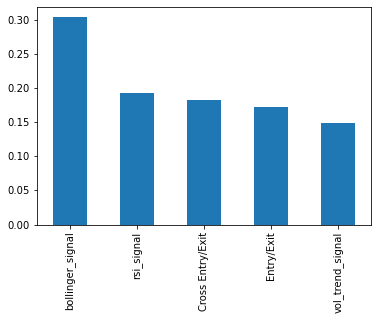

In [52]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [53]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [54]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [55]:
results["Predicted Value"].value_counts()

 0    287
-1     31
 1     19
Name: Predicted Value, dtype: int64

In [56]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                            
2021-07-11 12:00:00                0                0
2021-07-11 13:00:00                0                0
2021-07-11 14:00:00                0                0
2021-07-11 15:00:00                0                1
2021-07-11 16:00:00                0                0
2021-07-11 17:00:00                0                0
2021-07-11 18:00:00                0                0
2021-07-11 19:00:00                0                0
2021-07-11 20:00:00                0                0
2021-07-11 21:00:00                1                0

In [57]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

# note 0.69 considered good log loss - the higher the number the more the predicted value diverges from the actual (lower number is better)

0.9060429833341707

<AxesSubplot:xlabel='Timestamp'>

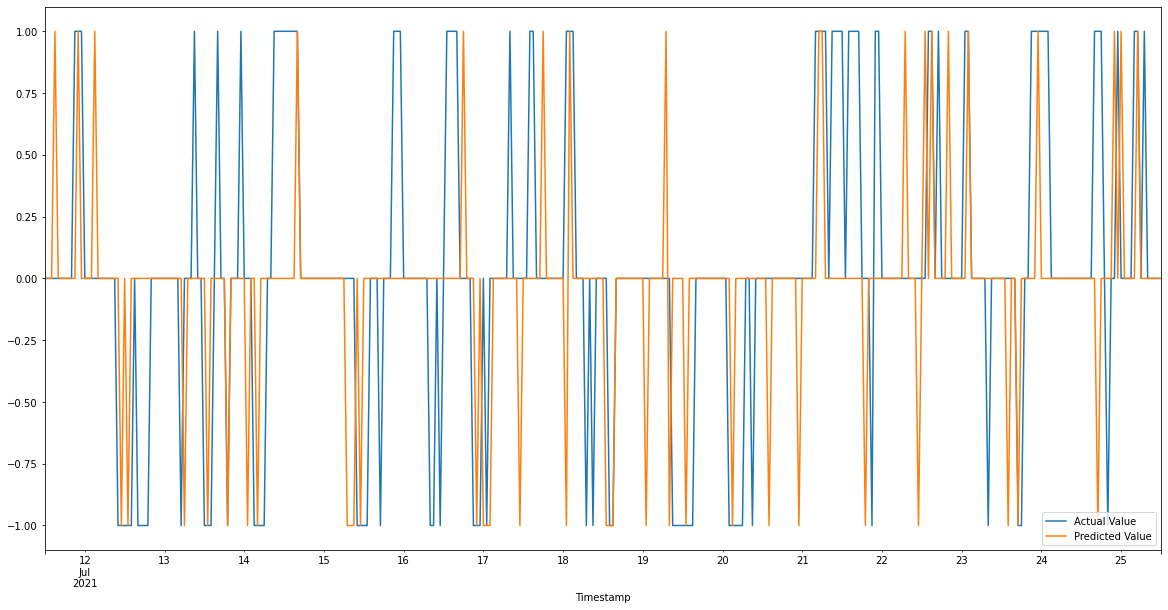

In [58]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Timestamp'>

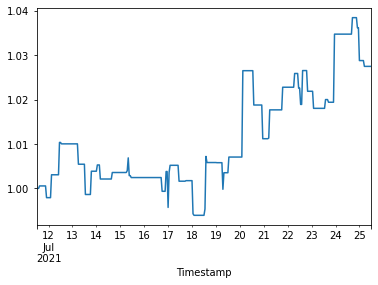

In [59]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Timestamp'>

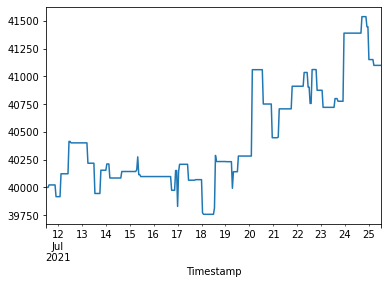

In [60]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [61]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [62]:
cumulative_return_capital.iloc[-1]

0    41098.387489
Name: 2021-07-25 12:00:00, dtype: float64

In [63]:
cumulative_return_capital.iloc[-1]


Full_Period_Return_41days = (cumulative_return_capital.iloc[-1] - initial_capital) * 5.5

RF_5_models = Full_Period_Return_41days.item() + initial_capital
RF_5_models


46041.13118955627

## 3 Model Input

In [64]:
trading_signals_df = btc_df.copy()

In [65]:
# Set x variable list of features
x_var_list = ["vol_trend_signal", "bollinger_signal","rsi_signal"]

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                          
2021-07-25 08:00:00               0.0               0.0         0.0
2021-07-25 09:00:00               0.0               0.0         0.0
2021-07-25 10:00:00               0.0               0.0         1.0
2021-07-25 11:00:00               0.0               0.0         0.0
2021-07-25 12:00:00               0.0               0.0         0.0

In [66]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                          
2021-05-16 00:00:00               NaN               NaN         NaN
2021-05-16 01:00:00               NaN               NaN         0.0
2021-05-16 02:00:00               0.0               0.0         0.0
2021-05-16 03:00:00              -1.0               0.0         0.0
2021-05-16 04:00:00               1.0               0.0         0.0

In [67]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
2021-05-16 05:00:00  48102.77  48354.20  48034.82  48165.86  1650.211541   
2021-05-16 06:00:00  48165.86  49500.00  48135.39  49047.97  4192.928903   
2021-05-16 07:00:00  49047.97  49400.00  48825.31  49375.28  2686.640493   
2021-05-16 08:00:00  49375.28  49437.46  48656.00  48900.02  2548.287369   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
2021-05-16 05:00:00       0.001312  0.002203  48099.601360  48050.422662   
2021-05-16 06:00:00       0.018314  0.018649  48343.680808  48224.194596   
2021-05-16 07:00:00       0.006673  0.020499  48596.281257  48405.293144   
2021-05-16 08:00:00      -0.009625  0.016574  48667.893992  48476.677394   

                     crossover_long  ...  vol_trend_signal  \
Timestamp                            ...                     
2021-05-16 04:00:00             1.0  ...               1.0   
2021-05-16 05:00:00             1.0  ...               0.0   
2021-05-16 06:00:00             1.0  ...               0.0   
2021-05-16 07:00:00             1.0  ...              -1.0   
2021-05-16 08:00:00             1.0  ...               1.0   

                     bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                                      
2021-05-16 04:00:00                 NaN            NaN                   NaN   
2021-05-16 05:00:00                 NaN            NaN                   NaN   
2021-05-16 06:00:00                 NaN            NaN                   NaN   
2021-05-16 07:00:00                 NaN            NaN                   NaN   
2021-05-16 08:00:00                 NaN            NaN                   NaN   

                     bollinger_lower_band  bollinger_long  bollinger_signal  \
Timestamp                                                                     
2021-05-16 04:00:00                   NaN             0.0               0.0   
2021-05-16 05:00:00                   NaN             0.0               0.0   
2021-05-16 06:00:00                   NaN             0.0               0.0   
2021-05-16 07:00:00                   NaN             0.0               0.0   
2021-05-16 08:00:00                   NaN             0.0               0.0   

                     rsi  rsi_long  rsi_signal  
Timestamp                                       
2021-05-16 04:00:00  NaN       0.0         0.0  
2021-05-16 05:00:00  NaN       0.0         0.0  
2021-05-16 06:00:00  NaN       0.0         0.0  
2021-05-16 07:00:00  NaN       0.0         0.0  
2021-05-16 08:00:00  NaN       0.0         0.0  

[5 rows x 37 columns]

In [68]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
2021-05-16 05:00:00  48102.77  48354.20  48034.82  48165.86  1650.211541   
2021-05-16 06:00:00  48165.86  49500.00  48135.39  49047.97  4192.928903   
2021-05-16 07:00:00  49047.97  49400.00  48825.31  49375.28  2686.640493   
2021-05-16 08:00:00  49375.28  49437.46  48656.00  48900.02  2548.287369   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
2021-05-16 05:00:00       0.001312  0.002203  48099.601360  48050.422662   
2021-05-16 06:00:00       0.018314  0.018649  48343.680808  48224.194596   
2021-05-16 07:00:00       0.006673  0.020499  48596.281257  48405.293144   
2021-05-16 08:00:00      -0.009625  0.016574  48667.893992  48476.677394   

                     crossover_long  ...  bollinger_mid_band  bollinger_std  \
Timestamp                            ...                                      
2021-05-16 04:00:00             1.0  ...                 NaN            NaN   
2021-05-16 05:00:00             1.0  ...                 NaN            NaN   
2021-05-16 06:00:00             1.0  ...                 NaN            NaN   
2021-05-16 07:00:00             1.0  ...                 NaN            NaN   
2021-05-16 08:00:00             1.0  ...                 NaN            NaN   

                     bollinger_upper_band  bollinger_lower_band  \
Timestamp                                                         
2021-05-16 04:00:00                   NaN                   NaN   
2021-05-16 05:00:00                   NaN                   NaN   
2021-05-16 06:00:00                   NaN                   NaN   
2021-05-16 07:00:00                   NaN                   NaN   
2021-05-16 08:00:00                   NaN                   NaN   

                     bollinger_long  bollinger_signal  rsi  rsi_long  \
Timestamp                                                              
2021-05-16 04:00:00             0.0               0.0  NaN       0.0   
2021-05-16 05:00:00             0.0               0.0  NaN       0.0   
2021-05-16 06:00:00             0.0               0.0  NaN       0.0   
2021-05-16 07:00:00             0.0               0.0  NaN       0.0   
2021-05-16 08:00:00             0.0               0.0  NaN       0.0   

                     rsi_signal  Positive Return  
Timestamp                                         
2021-05-16 04:00:00         0.0              1.0  
2021-05-16 05:00:00         0.0              1.0  
2021-05-16 06:00:00         0.0              1.0  
2021-05-16 07:00:00         0.0              1.0  
2021-05-16 08:00:00         0.0              1.0  

[5 rows x 38 columns]

In [69]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.01,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.01,'Positive Return'] = -1

In [70]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    832
-1    435
 1    422
Name: Positive Return, dtype: int64

In [71]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2021-05-16
Training End: 2021-07-11 11:00:00
Testing Start: 2021-07-11 12:00:00
Testing End: 2021-07-25


In [72]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                          
2021-07-11 07:00:00               0.0               0.0         0.0
2021-07-11 08:00:00               0.0               0.0         0.0
2021-07-11 09:00:00               0.0               0.0         0.0
2021-07-11 10:00:00               0.0               0.0         0.0
2021-07-11 11:00:00               0.0               0.0         0.0

Timestamp
2021-07-11 07:00:00    0
2021-07-11 08:00:00    0
2021-07-11 09:00:00    0
2021-07-11 10:00:00    0
2021-07-11 11:00:00    0
Name: Positive Return, dtype: int64

In [73]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                          
2021-07-25 08:00:00               0.0               0.0         0.0
2021-07-25 09:00:00               0.0               0.0         0.0
2021-07-25 10:00:00               0.0               0.0         0.0
2021-07-25 11:00:00               0.0               0.0         1.0
2021-07-25 12:00:00               0.0               0.0         0.0

Timestamp
2021-07-25 08:00:00    0
2021-07-25 09:00:00    0
2021-07-25 10:00:00    0
2021-07-25 11:00:00    0
2021-07-25 12:00:00    0
Name: Positive Return, dtype: int64

In [74]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    299
-1     24
 1     14
Name: Predicted Value, dtype: int64

<AxesSubplot:>

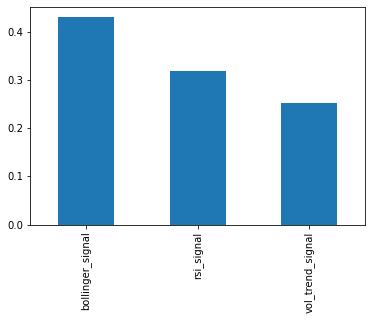

In [75]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [76]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [77]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [78]:
results["Predicted Value"].value_counts()

 0    299
-1     24
 1     14
Name: Predicted Value, dtype: int64

In [79]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                            
2021-07-11 12:00:00                0                0
2021-07-11 13:00:00                0                0
2021-07-11 14:00:00                0                0
2021-07-11 15:00:00                0                1
2021-07-11 16:00:00                0                0
2021-07-11 17:00:00                0                0
2021-07-11 18:00:00                0                0
2021-07-11 19:00:00                0                0
2021-07-11 20:00:00                0                0
2021-07-11 21:00:00                1                0

In [80]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

0.9209646586321146

<AxesSubplot:xlabel='Timestamp'>

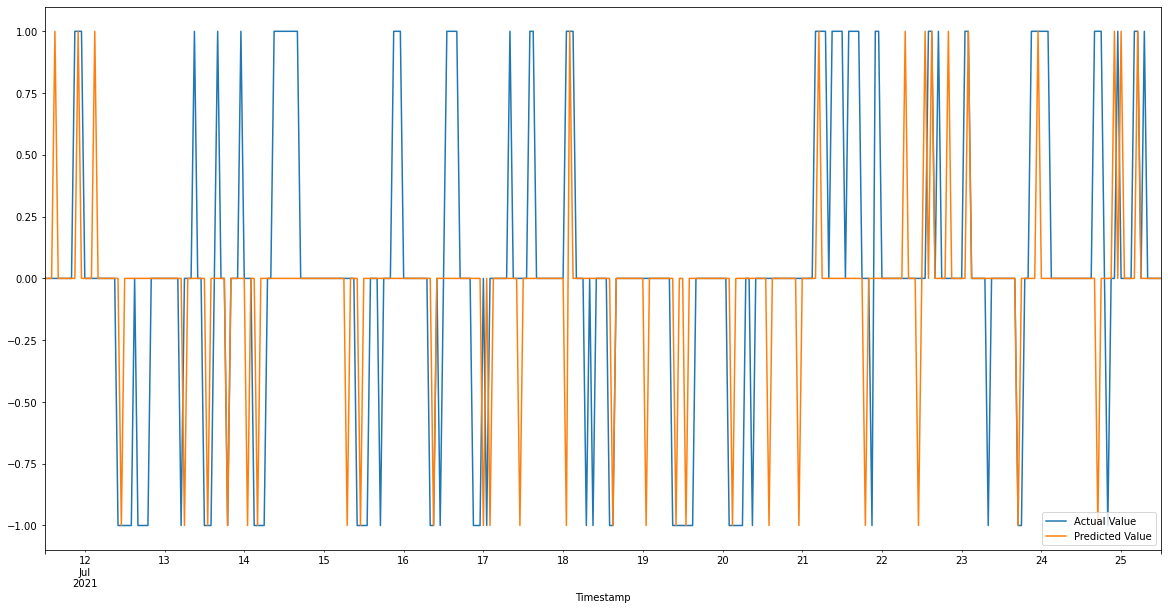

In [81]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Timestamp'>

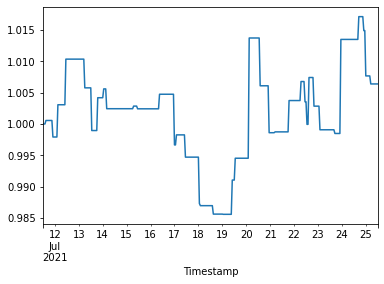

In [82]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Timestamp'>

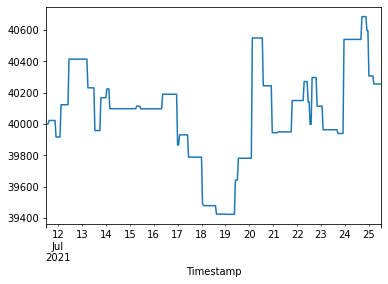

In [83]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [84]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [85]:
cumulative_return_capital.iloc[-1]
Full_Period_Return_41days = (cumulative_return_capital.iloc[-1] - initial_capital) * 5.5

RF_3_models = Full_Period_Return_41days.item() + initial_capital
RF_3_models


41405.50006426206

## 2 Model Input

In [86]:
trading_signals_df = btc_df.copy()

In [87]:
# Set x variable list of features
x_var_list = ["Cross Entry/Exit","Entry/Exit"]


# Filter by x-variable list
trading_signals_df[x_var_list].tail()

Cross Entry/Exit  Entry/Exit
Timestamp                                        
2021-07-25 08:00:00               0.0         0.0
2021-07-25 09:00:00               0.0         0.0
2021-07-25 10:00:00               0.0         0.0
2021-07-25 11:00:00               0.0         0.0
2021-07-25 12:00:00               0.0         0.0

In [88]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

Cross Entry/Exit  Entry/Exit
Timestamp                                        
2021-05-16 00:00:00               NaN         NaN
2021-05-16 01:00:00               0.0         NaN
2021-05-16 02:00:00               1.0         0.0
2021-05-16 03:00:00               0.0         0.0
2021-05-16 04:00:00               0.0         0.0

In [89]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
2021-05-16 05:00:00  48102.77  48354.20  48034.82  48165.86  1650.211541   
2021-05-16 06:00:00  48165.86  49500.00  48135.39  49047.97  4192.928903   
2021-05-16 07:00:00  49047.97  49400.00  48825.31  49375.28  2686.640493   
2021-05-16 08:00:00  49375.28  49437.46  48656.00  48900.02  2548.287369   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
2021-05-16 05:00:00       0.001312  0.002203  48099.601360  48050.422662   
2021-05-16 06:00:00       0.018314  0.018649  48343.680808  48224.194596   
2021-05-16 07:00:00       0.006673  0.020499  48596.281257  48405.293144   
2021-05-16 08:00:00      -0.009625  0.016574  48667.893992  48476.677394   

                     crossover_long  ...  vol_trend_signal  \
Timestamp                            ...                     
2021-05-16 04:00:00             1.0  ...               0.0   
2021-05-16 05:00:00             1.0  ...               0.0   
2021-05-16 06:00:00             1.0  ...              -1.0   
2021-05-16 07:00:00             1.0  ...               1.0   
2021-05-16 08:00:00             1.0  ...              -1.0   

                     bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                                      
2021-05-16 04:00:00                 NaN            NaN                   NaN   
2021-05-16 05:00:00                 NaN            NaN                   NaN   
2021-05-16 06:00:00                 NaN            NaN                   NaN   
2021-05-16 07:00:00                 NaN            NaN                   NaN   
2021-05-16 08:00:00                 NaN            NaN                   NaN   

                     bollinger_lower_band  bollinger_long  bollinger_signal  \
Timestamp                                                                     
2021-05-16 04:00:00                   NaN             0.0               0.0   
2021-05-16 05:00:00                   NaN             0.0               0.0   
2021-05-16 06:00:00                   NaN             0.0               0.0   
2021-05-16 07:00:00                   NaN             0.0               0.0   
2021-05-16 08:00:00                   NaN             0.0               0.0   

                     rsi  rsi_long  rsi_signal  
Timestamp                                       
2021-05-16 04:00:00  NaN       0.0         0.0  
2021-05-16 05:00:00  NaN       0.0         0.0  
2021-05-16 06:00:00  NaN       0.0         0.0  
2021-05-16 07:00:00  NaN       0.0         0.0  
2021-05-16 08:00:00  NaN       0.0         0.0  

[5 rows x 37 columns]

In [90]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open      High       Low     Close       Volume  \
Timestamp                                                                  
2021-05-16 04:00:00  48386.62  48951.01  48051.38  48102.77  2272.252438   
2021-05-16 05:00:00  48102.77  48354.20  48034.82  48165.86  1650.211541   
2021-05-16 06:00:00  48165.86  49500.00  48135.39  49047.97  4192.928903   
2021-05-16 07:00:00  49047.97  49400.00  48825.31  49375.28  2686.640493   
2021-05-16 08:00:00  49375.28  49437.46  48656.00  48900.02  2548.287369   

                     period_return    target    fast_close    slow_close  \
Timestamp                                                                  
2021-05-16 04:00:00      -0.005801  0.017328  48074.460457  48022.134751   
2021-05-16 05:00:00       0.001312  0.002203  48099.601360  48050.422662   
2021-05-16 06:00:00       0.018314  0.018649  48343.680808  48224.194596   
2021-05-16 07:00:00       0.006673  0.020499  48596.281257  48405.293144   
2021-05-16 08:00:00      -0.009625  0.016574  48667.893992  48476.677394   

                     crossover_long  ...  bollinger_mid_band  bollinger_std  \
Timestamp                            ...                                      
2021-05-16 04:00:00             1.0  ...                 NaN            NaN   
2021-05-16 05:00:00             1.0  ...                 NaN            NaN   
2021-05-16 06:00:00             1.0  ...                 NaN            NaN   
2021-05-16 07:00:00             1.0  ...                 NaN            NaN   
2021-05-16 08:00:00             1.0  ...                 NaN            NaN   

                     bollinger_upper_band  bollinger_lower_band  \
Timestamp                                                         
2021-05-16 04:00:00                   NaN                   NaN   
2021-05-16 05:00:00                   NaN                   NaN   
2021-05-16 06:00:00                   NaN                   NaN   
2021-05-16 07:00:00                   NaN                   NaN   
2021-05-16 08:00:00                   NaN                   NaN   

                     bollinger_long  bollinger_signal  rsi  rsi_long  \
Timestamp                                                              
2021-05-16 04:00:00             0.0               0.0  NaN       0.0   
2021-05-16 05:00:00             0.0               0.0  NaN       0.0   
2021-05-16 06:00:00             0.0               0.0  NaN       0.0   
2021-05-16 07:00:00             0.0               0.0  NaN       0.0   
2021-05-16 08:00:00             0.0               0.0  NaN       0.0   

                     rsi_signal  Positive Return  
Timestamp                                         
2021-05-16 04:00:00         0.0              1.0  
2021-05-16 05:00:00         0.0              1.0  
2021-05-16 06:00:00         0.0              1.0  
2021-05-16 07:00:00         0.0              1.0  
2021-05-16 08:00:00         0.0              1.0  

[5 rows x 38 columns]

In [91]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.01,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.01,'Positive Return'] = -1

In [92]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    832
-1    435
 1    422
Name: Positive Return, dtype: int64

In [93]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2021-05-16
Training End: 2021-07-11 11:00:00
Testing Start: 2021-07-11 12:00:00
Testing End: 2021-07-25


In [94]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Cross Entry/Exit  Entry/Exit
Timestamp                                        
2021-07-11 07:00:00               0.0         0.0
2021-07-11 08:00:00               0.0         0.0
2021-07-11 09:00:00               0.0         0.0
2021-07-11 10:00:00               1.0         0.0
2021-07-11 11:00:00               0.0         0.0

Timestamp
2021-07-11 07:00:00    0
2021-07-11 08:00:00    0
2021-07-11 09:00:00    0
2021-07-11 10:00:00    0
2021-07-11 11:00:00    0
Name: Positive Return, dtype: int64

In [95]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Cross Entry/Exit  Entry/Exit
Timestamp                                        
2021-07-25 08:00:00               0.0         0.0
2021-07-25 09:00:00               0.0         0.0
2021-07-25 10:00:00               0.0         0.0
2021-07-25 11:00:00               0.0         0.0
2021-07-25 12:00:00               0.0         0.0

Timestamp
2021-07-25 08:00:00    0
2021-07-25 09:00:00    0
2021-07-25 10:00:00    0
2021-07-25 11:00:00    0
2021-07-25 12:00:00    0
Name: Positive Return, dtype: int64

In [96]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    315
 1     11
-1     11
Name: Predicted Value, dtype: int64

<AxesSubplot:>

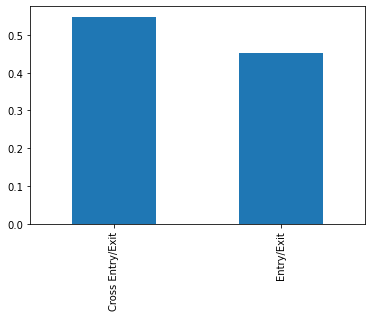

In [97]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [98]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [99]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [100]:
results["Predicted Value"].value_counts()

 0    315
 1     11
-1     11
Name: Predicted Value, dtype: int64

In [101]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                            
2021-07-11 12:00:00                0                1
2021-07-11 13:00:00                0                0
2021-07-11 14:00:00                0                0
2021-07-11 15:00:00                0                0
2021-07-11 16:00:00                0                0
2021-07-11 17:00:00                0                0
2021-07-11 18:00:00                0                0
2021-07-11 19:00:00                0                0
2021-07-11 20:00:00                0                0
2021-07-11 21:00:00                1                0

In [102]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

0.9436906317351964

<AxesSubplot:xlabel='Timestamp'>

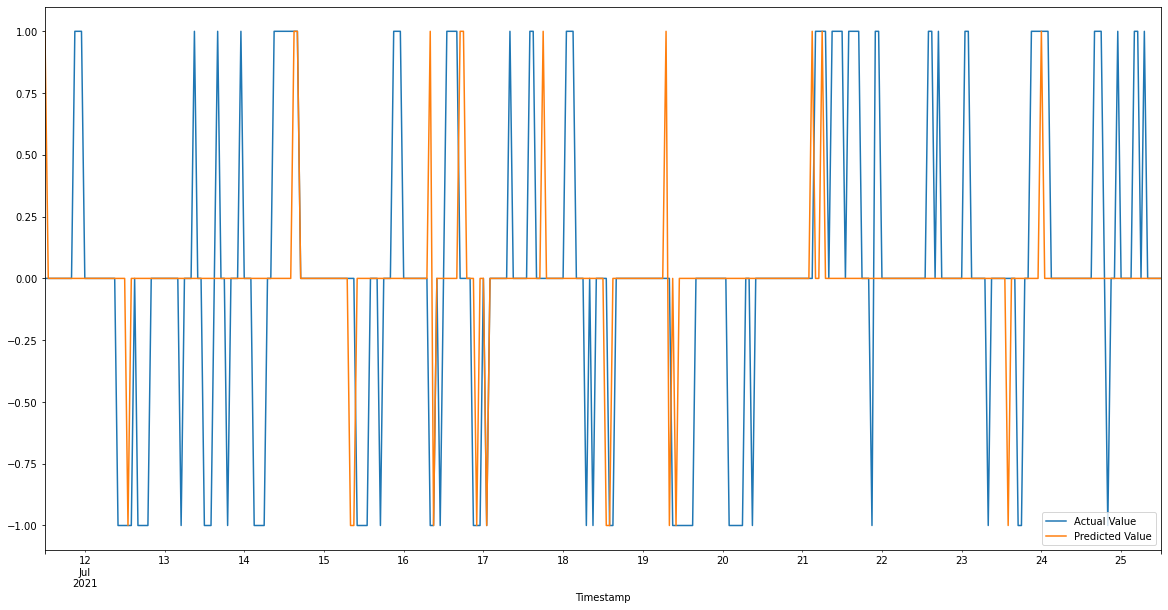

In [103]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Timestamp'>

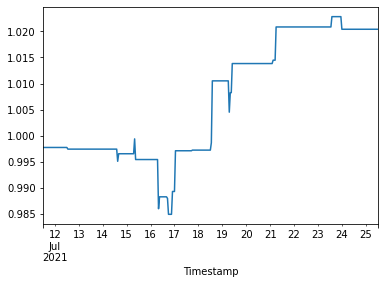

In [104]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Timestamp'>

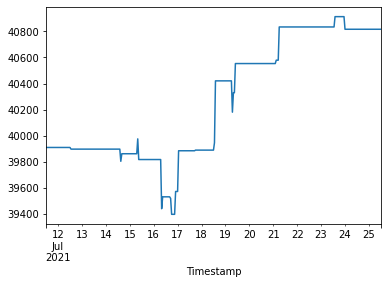

In [105]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [106]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [107]:
cumulative_return_capital.iloc[-1]
Full_Period_Return_41days = (cumulative_return_capital.iloc[-1] - initial_capital) * 5.5

RF_2_models = Full_Period_Return_41days.item() + initial_capital
RF_2_models

44492.679216582765

### Create new DataFrame to capture results 


In [108]:
comparison_data = [['EWM', EMA ],['SMA', SMA],['Volatility', VOL],['Bollinger', BOL],['RSI', RSI],['RFC_5', RF_5_models],['RFC_3', RF_3_models],['RFC_2', RF_2_models]]
comp_df = pd.DataFrame(comparison_data)
comp_df.columns=['Method','Ending Portfolio Value']
comp_df["% Return on Capital"]=((comp_df["Ending Portfolio Value"]-hounds_cap_investment)/hounds_cap_investment)* 100
comp_df.set_index("Method", inplace= True)
comp_df = comp_df.round(decimals=2)
comp_df = comp_df.sort_values(by=['% Return on Capital'], axis=0, ascending=False)
comp_df


Ending Portfolio Value  % Return on Capital
Method                                                 
RFC_5                     46041.13                15.10
RFC_2                     44492.68                11.23
Volatility                42422.25                 6.06
EWM                       41601.89                 4.00
RFC_3                     41405.50                 3.51
RSI                       36423.94                -8.94
Bollinger                 33331.86               -16.67
SMA                       32472.69               -18.82

<AxesSubplot:xlabel='Method'>

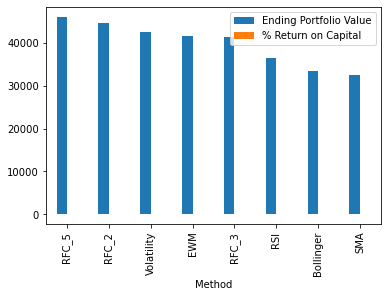

In [109]:
comp_df.plot.bar()